<center><h1>CSCI 4140: Natural Language Processing</h1></center>
<center><h1>CSCI/DASC 6040: Computational Analysis of Natural Languages</h1></center>

<center><h6>Spring 2023</h6></center>
<center><h6>Homework 2 - Types, tokens and Zipf's law; sentiment analysis with naive Bayes</h6></center>
<center><h6>Due Sunday, February 12, at 11:59 PM</h6></center>

<font color='red'>Do not redistribute without the instructor’s written permission.</font>

In [1]:
# Run this cell! It sets some things up for you.

from __future__ import division  # this line is important to avoid unexpected behavior from division
import matplotlib.pyplot as plt
import os
import zipfile
import math
import time
import operator
from collections import defaultdict, Counter

%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 4) # set default size of plots

if not os.path.isdir('data'):
    os.mkdir('data')  # make the data directory

# Extract the data from the zipfile and put it into the data directory
with zipfile.ZipFile('large_movie_review_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
print("IMDb data extracted!")

PATH_TO_DATA = 'data/large_movie_review_dataset'  # path to the data directory
POS_LABEL = 'pos'
NEG_LABEL = 'neg'
TRAIN_DIR = os.path.join(PATH_TO_DATA, "train")
TEST_DIR = os.path.join(PATH_TO_DATA, "test")

for label in [POS_LABEL, NEG_LABEL]:
    if len(os.listdir(TRAIN_DIR + "/" + label)) == 12500:
        print ("Great! You have 12500 {} reviews in {}".format(label, TRAIN_DIR + "/" + label))
    else:
        print ("Oh no! Something is wrong. Check your code which loads the reviews")

IMDb data extracted!
Great! You have 12500 pos reviews in data/large_movie_review_dataset\train/pos
Great! You have 12500 neg reviews in data/large_movie_review_dataset\train/neg


In [2]:
# Actually reading the data you are working with is an important part of NLP! Let's look at one of these reviews

print (open(TRAIN_DIR + "/neg/98_1.txt").read())

I received this movie as a gift, I knew from the DVD cover, this movie are going to be bad.After not watching it for more than a year I finally watched it. what a pathetic movieÂ….<br /><br />I almost didn't finish watching this bad movie,but it will be unfair of me to write a review without watching the complete movie.<br /><br />Trust me when I say " this movie sucks" I am truly shocked that some bad filmmaker wane bee got even financed to make this pathetic movie, But it couldn't have cost more than $20 000 to produce this movie. all you need are a cheap camcorder or a cell phone camera .about 15 people with no acting skills, a scrip that were written by a couple of drunk people.<br /><br />In the fist part of this ultra bad move a reporter (Tara Woodley )run a suppose to be drunk man over on her way to report on a hunted town. He are completely unharmed. They went to a supposed to be abandon house ,but luckily for the it almost complete furnished and a bottle of liquor on the door 

# Preprocessing Block
<a id='Preprocessing-Block'></a>
The following cell contains code that will be referred to as the `Preprocessing Block` from now on. It contains a function that tokenizes the document passed to it, and functions that return counts of word types and tokens.

In [25]:
###### PREPROCESSING BLOCK ######

###### DO NOT MODIFY THIS FUNCTION #####
def tokenize_doc(doc):
    """
    Tokenize a document and return its bag-of-words representation.
    doc - a string representing a document.
    returns a dictionary mapping each word to the number of times it appears in doc.
    """
    bow = defaultdict(float)
    tokens = doc.split()
    lowered_tokens = map(lambda t: t.lower(), tokens)
    for token in lowered_tokens:
        bow[token] += 1.0
    return dict(bow)
###### END FUNCTION #####

def n_word_types(word_counts):
    '''
    Implement Me!
    return a count of all word types in the corpus
    using information from word_counts
    '''
    return len(word_counts)


def n_word_tokens(word_counts):
    '''
    Implement Me!
    return a count of all word tokens in the corpus
    using information from word_counts
    '''
    return sum(word_counts.values())

# Naive Bayes Block
<a id='Naive-Bayes-Block'></a>
This next block of code (referred to as `Naive Bayes Block` from now on) is something you will keep coming back to throughout the course of the assignment. There are several functions you need to implement here, that will be called in later parts of the assignment. Familiarize yourself with what each function does, as well as how everything comes together.

In [5]:
###### NAIVE BAYES BLOCK ######

class NaiveBayes:
    """A Naive Bayes model for text classification."""

    def __init__(self, path_to_data, tokenizer):
        # Vocabulary is a set that stores every word seen in the training data
        self.vocab = set()
        self.path_to_data = path_to_data
        self.tokenize_doc = tokenizer
        self.train_dir = os.path.join(path_to_data, "train")
        self.test_dir = os.path.join(path_to_data, "test")
        # class_total_doc_counts is a dictionary that maps a class (i.e., pos/neg) to
        # the number of documents in the trainning set of that class
        self.class_total_doc_counts = { POS_LABEL: 0.0,
                                        NEG_LABEL: 0.0 }

        # class_total_word_counts is a dictionary that maps a class (i.e., pos/neg) to
        # the number of words in the training set in documents of that class
        self.class_total_word_counts = { POS_LABEL: 0.0,
                                         NEG_LABEL: 0.0 }

        # class_word_counts is a dictionary of dictionaries. It maps a class (i.e.,
        # pos/neg) to a dictionary of word counts. For example:
        #    self.class_word_counts[POS_LABEL]['awesome']
        # stores the number of times the word 'awesome' appears in documents
        # of the positive class in the training documents.
        self.class_word_counts = { POS_LABEL: defaultdict(float),
                                   NEG_LABEL: defaultdict(float) }

    def train_model(self):
        """
        This function processes the entire training set using the global PATH
        variable above.  It makes use of the tokenize_doc and update_model
        functions you will implement.
        """

        pos_path = os.path.join(self.train_dir, POS_LABEL)
        neg_path = os.path.join(self.train_dir, NEG_LABEL)
        for (p, label) in [ (pos_path, POS_LABEL), (neg_path, NEG_LABEL) ]:
            for f in os.listdir(p):
                with open(os.path.join(p,f),'r') as doc:
                    content = doc.read()
                    self.tokenize_and_update_model(content, label)
        self.report_statistics_after_training()

    def report_statistics_after_training(self):
        """
        Report a number of statistics after training.
        """

        print ("REPORTING CORPUS STATISTICS")
        print ("NUMBER OF DOCUMENTS IN POSITIVE CLASS:", self.class_total_doc_counts[POS_LABEL])
        print ("NUMBER OF DOCUMENTS IN NEGATIVE CLASS:", self.class_total_doc_counts[NEG_LABEL])
        print ("NUMBER OF TOKENS IN POSITIVE CLASS:", self.class_total_word_counts[POS_LABEL])
        print ("NUMBER OF TOKENS IN NEGATIVE CLASS:", self.class_total_word_counts[NEG_LABEL])
        print ("VOCABULARY SIZE: NUMBER OF UNIQUE WORDTYPES IN TRAINING CORPUS:", len(self.vocab))

    def update_model(self, bow, label):
        """
        Implement me!

        Update internal statistics given a document represented as a bag-of-words
        bow - a map from words to their counts
        label - the class of the document whose bag-of-words representation was input
        This function doesn't return anything but should update a number of internal
        statistics. Specifically, it updates:
          - the internal map the counts, per class, how many times each word was
            seen (self.class_word_counts)
          - the number of words seen for each label (self.class_total_word_counts)
          - the vocabulary seen so far (self.vocab)
          - the number of documents seen of each label (self.class_total_doc_counts)
        """
        for word, count in bow.items():
            if word not in self.vocab:
                self.vocab.add(word)
            if label not in self.class_word_counts:
                self.class_word_counts[label] = {}
            if word not in self.class_word_counts[label]:
                self.class_word_counts[label][word] = 0
            self.class_word_counts[label][word] += count
        if label not in self.class_total_word_counts:
            self.class_total_word_counts[label] = 0
        self.class_total_word_counts[label] += sum(bow.values())
        if label not in self.class_total_doc_counts:
            self.class_total_doc_counts[label] = 0
        self.class_total_doc_counts[label] += 1

    def tokenize_and_update_model(self, doc, label):
        """
        Implement me!

        Tokenizes a document doc and updates internal count statistics.
        doc - a string representing a document.
        label - the sentiment of the document (either postive or negative)
        stop_word - a boolean flag indicating whether to stop word or not

        Make sure when tokenizing to lower case all of the tokens!
        """
        tokens = [token.lower() for token in nltk.word_tokenize(doc)]
        bow = Counter(tokens)
        self.update_model(bow, label)

    def top_n(self, label, n):
        """
        Implement me!
        
        Returns the most frequent n tokens for documents with class 'label'.
        """
        word_counts = self.class_word_counts[label]
        sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        top_n_words = [word for word, count in sorted_word_counts[:n]]
        return top_n_words

    def p_word_given_label(self, word, label):
        """
        Implement me!

        Returns the probability of word given label
        according to this NB model.
        """
        word_counts = self.class_word_counts[label]
        total_word_count = self.class_total_word_counts[label]
        return (word_counts[word] + 1) / (total_word_count + len(self.vocab))

    def p_word_given_label_and_alpha(self, word, label, alpha):
        """
        Implement me!

        Returns the probability of word given label wrt psuedo counts.
        alpha - pseudocount parameter
        """
        word_counts = self.class_word_counts[label]
        total_word_count = self.class_total_word_counts[label]
        return (word_counts.get(word, 0) + alpha) / (total_word_count + alpha * len(self.vocab))

    def log_likelihood(self, bow, label, alpha):
        """
        Implement me!

        Computes the log likelihood of a set of words given a label and pseudocount.
        bow - a bag of words (i.e., a tokenized document)
        label - either the positive or negative label
        alpha - float; pseudocount parameter
        """
        log_likelihood = 0
        for word, count in bow.items():
            p_word = self.p_word_given_label_and_alpha(word, label, alpha)
            log_likelihood += count * math.log(p_word)
        return log_likelihood

    def log_prior(self, label):
        """
        Implement me!

        Returns the log prior of a document having the class 'label'.
        """
        total_docs = sum(self.class_total_doc_counts.values())
        p_label = self.class_total_doc_counts[label] / total_docs
        return math.log(p_label)

    def unnormalized_log_posterior(self, bow, label, alpha):
        """
        Implement me!

        Computes the unnormalized log posterior (of doc being of class 'label').
        bow - a bag of words (i.e., a tokenized document)
        """
        log_prior = self.log_prior(label)
        log_likelihood = self.log_likelihood(bow, label, alpha)
        return log_prior + log_likelihood

    def classify(self, bow, alpha):
        """
        Implement me!

        Compares the unnormalized log posterior for doc for both the positive
        and negative classes and returns the either POS_LABEL or NEG_LABEL
        (depending on which resulted in the higher unnormalized log posterior)
        bow - a bag of words (i.e., a tokenized document)
        """
        pos_unnormalized_log_posterior = self.unnormalized_log_posterior(bow, self.POS_LABEL, alpha)
        neg_unnormalized_log_posterior = self.unnormalized_log_posterior(bow, self.NEG_LABEL, alpha)

        if pos_unnormalized_log_posterior > neg_unnormalized_log_posterior:
            return self.POS_LABEL
        else:
            return self.NEG_LABEL

    def likelihood_ratio(self, word, alpha):
        """
        Implement me!

        Returns the ratio of P(word|pos) to P(word|neg).
        """
        pos_prob = self.p_word_given_label_and_alpha(word, self.POS_LABEL, alpha)
        neg_prob = self.p_word_given_label_and_alpha(word, self.NEG_LABEL, alpha)
        return pos_prob / neg_prob

    def evaluate_classifier_accuracy(self, alpha):
        """
        DO NOT MODIFY THIS FUNCTION

        alpha - pseudocount parameter.
        This function should go through the test data, classify each instance and
        compute the accuracy of the classifier (the fraction of classifications
        the classifier gets right.
        """
        correct = 0.0
        total = 0.0

        pos_path = os.path.join(self.test_dir, POS_LABEL)
        neg_path = os.path.join(self.test_dir, NEG_LABEL)
        for (p, label) in [ (pos_path, POS_LABEL), (neg_path, NEG_LABEL) ]:
            for f in os.listdir(p):
                with open(os.path.join(p,f),'r') as doc:
                    content = doc.read()
                    bow = self.tokenize_doc(content)
                    if self.classify(bow, alpha) == label:
                        correct += 1.0
                    total += 1.0
        return 100 * correct / total

# Part One: Intro to NLP in Python: types, tokens and Zipf's law

## Types and tokens

One major part of any NLP project is word tokenization. Word tokenization is the task of segmenting text into individual words, called tokens. In this assignment, we will use simple whitespace tokenization. Take a look at the `tokenize_doc` function in the [Preprocessing Block](#Preprocessing-Block) above. **You should not modify tokenize_doc** but make sure you understand what it is doing.

In [26]:
d1 = "This SAMPLE doc has   words tHat  repeat repeat"
bow = tokenize_doc(d1)

assert bow['this'] == 1
assert bow['sample'] == 1
assert bow['doc'] == 1
assert bow['has'] == 1
assert bow['words'] == 1
assert bow['that'] == 1
assert bow['repeat'] == 2

bow2 = tokenize_doc("NLP is my favorite class this semester!")
for b in bow2:
    print (b)

nlp
is
my
favorite
class
this
semester!


Now we are going to look at the word types and word tokens in the corpus.
Use the `word_counts` dictionary variable to store the count of each word in the corpus.
Use the `tokenize_doc` function to break documents into tokens. **You should not modify tokenize_doc** but make sure you understand what it is doing.

### Question 1.1 (5 points)

Complete the cell below to fill out the `word_counts` dictionary variable. `word_counts` keeps track of how many times a word type appears across the corpus. For instance, `word_counts["movie"]` should store the number 61492, the count of how many times the word `movie` appears in the corpus.

In [72]:
import glob
import codecs
import re
word_counts = Counter() # Counters are often useful for NLP in python

for label in [POS_LABEL, NEG_LABEL]:
    for directory in [TRAIN_DIR, TEST_DIR]:
        for fn in glob.glob(directory + "/" + label + "/*txt"):
            doc = codecs.open(fn, 'r', 'utf8') # Open the file with UTF-8 encoding
            contents = doc.read()
            tokens = tokenize_doc(contents)
            word_counts.update(tokens)

In [73]:
if word_counts["movie"] == 61492:
    print ("yay! there are {} total instances of the word type movie in the corpus".format(word_counts["movie"]))
else:
    print ("hmm. Something seems off. Double check your code")

yay! there are 61492.0 total instances of the word type movie in the corpus


### Question 1.2 (5 points)

Fill out the functions `n_word_types`, `n_word_tokens` in the [Preprocessing Block](#Preprocessing-Block).

***Note: you will have to rerun the `Preprocessing Block` cell every time you change its code for it to have any effect!***

In [54]:
print ("there are {} word types in the corpus".format(n_word_types(word_counts)))
print ("there are {} word tokens in the corpus".format(n_word_tokens(word_counts)))

there are 181066 word types in the corpus
there are 6972546 word tokens in the corpus


<font color='red'>What is the difference between word types and tokens? Why are the number of tokens much higher than the number of types?</font>

***Answer in one or two lines here.***

`n_word_types` function counts the number of unique words in the corpus.

`n_word_tokens` function counts the total number of words in the corpus.

### Question 1.3 (5 points)

Using the `word_counts` dictionary you just created, make a new dictionary called `sorted_dict` where the words are sorted according to their counts, in decending order:

In [74]:
sorted_dict = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

Now print the first 30 values from sorted_dict.

In [75]:
for i, (word, count) in enumerate(sorted_dict.items()):
    if i == 30:
        break
    print(f"{word}: {count}")

the: 638861.0
a: 316615.0
and: 313637.0
of: 286661.0
to: 264573.0
is: 204876.0
in: 179807.0
i: 141587.0
this: 138483.0
that: 130140.0
it: 129614.0
/><br: 100974.0
was: 93258.0
as: 88242.0
with: 84590.0
for: 84510.0
but: 77864.0
on: 62890.0
movie: 61492.0
are: 57009.0
his: 56870.0
not: 56765.0
you: 55600.0
film: 55086.0
have: 54423.0
he: 51062.0
be: 50901.0
at: 45259.0
one: 44983.0
by: 43359.0


## Zipf's Law

### Question 1.4 (10 points)

In this section, you will verify a key statistical property of text: [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law).

Zipf's Law describes the relations between the frequency rank of words and frequency value of words.  For a word $w$, its frequency is inversely proportional to its rank:

$$count_w = K \frac{1}{rank_w}$$

$K$ is a constant, specific to the corpus and how words are being defined.

<font color='red'>What would this look like if you took the log of both sides of the equation?</font>

***Answer in one or two lines here.***

Therefore, if Zipf's Law holds, after sorting the words descending on frequency, word frequency decreases in an approximately linear fashion under a log-log scale.

<font color='red'>Now, please make such a log-log plot by plotting the rank versus frequency</font>

*Hint: Make use of the sorted dictionary you just created.*
Use a scatter plot where the x-axis is the *log(rank)*, and y-axis is *log(frequency)*.  You should get this information from `word_counts`; for example, you can take the individual word counts and sort them.  dict methods `.items()` and/or `values()` may be useful.  (Note that it doesn't really matter whether ranks start at 1 or 0 in terms of how the plot comes out.) You can check your results by comparing your plots to ones on Wikipedia; they should look qualitatively similar.

*Please remember to label the meaning of the x-axis and y-axis.*

Text(0, 0.5, 'log(frequency)')

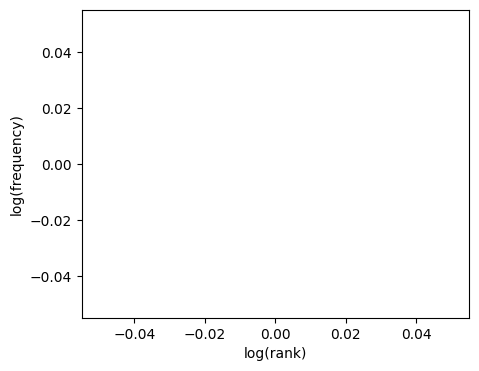

In [55]:
import math
import operator
x = []
y = []
X_LABEL = "log(rank)"
Y_LABEL = "log(frequency)"

# Add your code here
# You should fill the x and y arrays.
# Running this cell should produce your plot below.

plt.scatter(x, y)
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)

# Part Two: Naive Bayes

This section of the homework will walk you through coding a Naive Bayes classifier that can distinguish between positive and negative reviews (with some level of accuracy).

## Question 2.1 (10 pts)

To start, implement the `update_model` and `tokenize_and_update_model` functions in the [Naive Bayes Block](#Naive-Bayes-Block). Make sure to read the functions' comments so you know what to update. Also review the `NaiveBayes` class variables in the `def __init__` method of the `NaiveBayes class` to get a sense of which statistics are important to keep track of. Once you have implemented `update_model`, run the train model function using the code below.

In [56]:
nb = NaiveBayes(PATH_TO_DATA, tokenizer=tokenize_doc)
nb.train_model()

if len(nb.vocab) == 251637:
    print ("Great! The vocabulary size is {}".format(251637))
else:
    print ("Oh no! Something seems off. Double check your code before continuing. Maybe a mistake in update_model?")

NameError: name 'nltk' is not defined

## Exploratory analysis

Let’s begin to explore the count statistics stored by the update model function. Implement the provided `top_n` function in the [Naive Bayes Block](#Naive-Bayes-Block) to find the top 10 most common words in the positive class and top 10 most common words in the negative class. 

In [57]:
print ("TOP 10 WORDS FOR CLASS " + POS_LABEL + ":")
for tok, count in nb.top_n(POS_LABEL, 10):
    print ('', tok, count)
print ()

print ("TOP 10 WORDS FOR CLASS " + NEG_LABEL + ":")
for tok, count in nb.top_n(NEG_LABEL, 10):
    print ('', tok, count)
print ()

TOP 10 WORDS FOR CLASS pos:

TOP 10 WORDS FOR CLASS neg:



### Question 2.2 (5 points)

<font color='red'>What is the first thing that you notice when you look at the top 10 words for the 2 classes? Are these words helpful for discriminating between the two classes? Do you imagine that processing other English text will result in a similar phenomenon? What about other languages?</font>

***Answer in one or two lines here.***

### Question 2.3 (5 points)

The Naive Bayes model assumes that all features are conditionally independent given the class label. For our purposes, this means that the probability of seeing a particular word in a document with class label $y$ is independent of the rest of the words in that document. Implement the `p_word_given_label` function in the [Naive Bayes Block](#Naive-Bayes-Block). This function calculates P (w|y) (i.e., the probability of seeing word w in a document given the label of that document is y).

Use your `p_word_given_label` function to compute the probability of seeing the word “amazing” given each sentiment label. Repeat the computation for the word “dull.” 

In [58]:
print ("P('amazing'|pos):",  nb.p_word_given_label("amazing", POS_LABEL))
print ("P('amazing'|neg):",  nb.p_word_given_label("amazing", NEG_LABEL))
print ("P('dull'|pos):",  nb.p_word_given_label("dull", POS_LABEL))
print ("P('dull'|neg):",  nb.p_word_given_label("dull", NEG_LABEL))

ZeroDivisionError: float division by zero

<font color='red'>Which word has a higher probability, given the positive class? Which word has a higher probability, given the negative class? Is this behavior expected?</font>

***Answer in one or two lines here.***

### Question 2.4 (5 points)

In the next cell, compute the probability of the word "car-thievery" in the positive training data and negative training data.

In [59]:
print ("P('car-thievery'|pos):",  nb.p_word_given_label("car-thievery", POS_LABEL))
print ("P('car-thievery'|neg):",  nb.p_word_given_label("car-thievery", NEG_LABEL))

ZeroDivisionError: float division by zero

<font color='red'>What is unusual about P('car-thievery'|neg)? What would happen if we took the log of "P('car-thievery'|neg)"? What would happen if we multiplied "P('car-thievery'|neg)" by "P('dull'|neg)"? Why might these operations cause problems for a Naive Bayes classifier?</font>

***Answer in one or two lines here.***

### Question 2.5 (5 points)

We can address the issues from question 2.4 with add-$\alpha$ smoothing (like add-1 smoothing except instead of adding 1 we add $\alpha$). Implement
`p_word_given_label_and_alpha` in the [Naive Bayes Block](#Naive-Bayes-Block) and then run the next cell.

**Hint:** look at the slides from the lecture on add-1 smoothing.

In [60]:
print ("P('stop-sign.'|pos):",  nb.p_word_given_label_and_alpha("stop-sign.", POS_LABEL, 0.2))

ZeroDivisionError: float division by zero

### Question 2.6 (5 points)

*Prior and Likelihood* 

As noted before, the Naive Bayes model assumes that all words in a document are independent of one another given the document’s label. Because of this we can write the likelihood of a document as:

$P(w_{d1},\cdots,w_{dn}|y_d) = \prod_{i=1}^{n}P(w_{di}|y_d)$

However, if a document has a lot of words, the likelihood will become extremely small and we’ll encounter numerical underflow. Underflow is a common problem when dealing with probabilistic models; if you are unfamiliar with it, you can get a brief overview on [Wikipedia](https:/en.wikipedia.org/wiki/Arithmetic_underflow). To deal with underflow, a common transformation is to work in log-space.

$\log[P(w_{d1},\cdots,w_{dn}|y_d)] = \sum_{i=1}^{n}\log[P(w_{di}|y_d)]$

Implement the `log_likelihood` function in the [Naive Bayes Block](#Naive-Bayes-Block). **Hint:** it should make calls to the p word given label and alpha function.

Implement the `log_prior` function in the [Naive Bayes Block](#Naive-Bayes-Block). This function takes a class label and returns the log of the fraction of the training documents that are of that label.

### Question 2.7 (5 points)

Naive Bayes is a model that tells us how to compute the posterior
probability of a document being of some label (i.e.,
$P(y_d|\mathbf{w_d})$).  Specifically, we do so using bayes rule:

  $P(y_d|\mathbf{w_d}) = \frac{P(y_d)P(\mathbf{w_d}|y_d)}{P(\mathbf{w_d})}$

In the previous section you implemented functions to compute both
the log prior ($\log[P(y_d)]$) and the log likelihood
($\log[P( \mathbf{w_d} |y_d)]$ ). Now, all you're missing is the
*normalizer*, $P(\mathbf{w_d})$.

<font color='red'>Derive the normalizer by expanding $P(\mathbf{w_d})$.</font>

***Answer in one or two lines here. Provide the formula and define each term in this formula.***

### Question 2.8 (5 points)

One way to classify a document is to compute the unnormalized log posterior for both labels and take the argmax (i.e., the label that yields the higher unnormalized log posterior). The unnormalized log posterior is the sum of the log prior and the log likelihood of the document. <font color='red'>Why don’t we need to compute the log normalizer here?</font>

***Answer in one or two lines here.***

### Question 2.9 (10 points)

As we saw earlier, the top 10 words from each class do not give us much to go on when classifying a document. A much more powerful metric is the likelihood ratio, which is defined as

$LR(w)=\frac{P(w|y=\mathrm{pos})}{P(w|y=\mathrm{neg})}$

A word with LR 3 is 3 times more likely to appear in the positive class than in the negative. A word with LR 0.3 is one-third as likely to appear in the positive class as opposed to the negative class.

In [ ]:
# Implement the nb.likelihod_ratio function and use it to investigate the likelihood ratio of "amazing" and "dull"
print ("LIKELIHOOD RATIO OF 'amazing':", nb.likelihood_ratio('amazing', 0.2))
print ("LIKELIHOOD RATIO OF 'dull':", nb.likelihood_ratio('dull', 0.2))
print ("LIKELIHOOD RATIO OF 'and':", nb.likelihood_ratio('and', 0.2))
print ("LIKELIHOOD RATIO OF 'to':", nb.likelihood_ratio('to', 0.2))

<font color='red'>What is the minimum and maximum possible values the likelihood ratio can take? Does it make sense that $LR('amazing') > LR('to')$?</font>

***Answer in one or two lines here.***

Find the word in the vocabulary with the highest liklihood ratio below.

In [ ]:
# Add your code here

### Question 2.10 (5 points)

The unnormalized log posterior is the sum of the log prior and the log likelihood of the document. Implement the `unnormalized_log_posterior` function and the `classify` function in the [Naive Bayes Block](#Naive-Bayes-Block). The `classify` function should use the unnormalized log posteriors but should not compute the normalizer. Once you implement the `classify` function, we'd like to evaluate its accuracy.

In [ ]:
print (nb.evaluate_classifier_accuracy(0.2))

### Question 2.11 (5 points)

Try evaluating your model again with a smoothing parameter of 1000.

In [ ]:
print (nb.evaluate_classifier_accuracy(1000.0))

<font color='red'>Does the accuracy go up or down when alpha is raised to 1000? Why do you think this is?</font>

***Answer in one or two lines here.***

### Question 2.12 (5 points)

Find a review that your classifier got wrong. 

In [ ]:
# In this cell, print out a review your classifier got wrong, along with its label.

<font color='red'>What are two reasons your system might have misclassified this example? What improvements could you make that may help your system classify this example correctly?</font>

***Answer in one or two lines here.***

### Question 2.13 (5 points)

Often times we care about multi-class classification rather than binary classification.

<font color='red'>How many counts would we need to keep track of if the model were modified to support 5-class classification?</font>

***Answer in one or two lines here.***

## Extra Credit (Up to 10 points)

If you don't want to do the extra credit, you can stop here! Otherwise... keep reading...
In this assignment, we use whitespace tokenization to create a bag-of-unigrams representation for the movie reviews. It is possible to improve this represetation to improve your classifier's performance. Use your own code or an external library such as nltk to perform tokenization, text normalization, word filtering, etc. Fill out your work in `def tokenize_doc_and_more` (below) and then show improvement by running the cells below.

Roughly speaking, the larger performance improvement, the more extra credit. We will also give points for the effort in the evaluation and analysis process. For example, you can split the training data into training and validation set to prevent overfitting, and report results from trying different versions of features. You can also provide some qualitative examples you found in the dataset to support your choices on preprocessing steps. Whatever you choose to try, make sure to describe your method and the reasons that you hypothesize for why the method works. Be sure to explain what your code is doing.

In [ ]:
def tokenize_doc_and_more(doc): 
    """
    Return some representation of a document.
    At a minimum, you need to perform tokenization, the rest is up to you. 
    """
    # Implement me!
    bow = defaultdict(float)
    # your code goes here

    return bow

In [ ]:
nb = NaiveBayes(PATH_TO_DATA, tokenizer=tokenize_doc_and_more)
nb.train_model()
nb.evaluate_classifier_accuracy(1.0)

Use cells at the bottom of this notebook to explain what you did in `tokenize_doc_and_more`. Include any experiments or explanations that you used to decide what goes in your function. Doing a good job examining, explaining and justifying your work with small experiments and comments is as important as making the accuracy number go up!

***Explain what you did here.***

# How to submit this problem set:
- Write all the answers in this iPython notebook. Once you are finished (1) generate the PDF file (`File -> Print Preview`, and print to PDF), 2) ZIP the PDF and this Jupyter Notebook (.ipynb), and 3) upload the ZIP file to Canvas.
  
- **Important:** check your PDF before you turn it in to Canvas to make sure it exported correctly.

- When creating your final version of the PDF to hand in, please do a fresh restart and execute every cell in order. Then you'll be sure it's actually right. One handy way to do this is by clicking `Runtime -> Run All` in the notebook menu.